In [1]:
import sys
import optuna

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

sys.path.append('../src/brazil_streamflow')
import pytorch_functions as ptf

/home/michael/miniconda3/envs/brazil_streamflow_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/michael/miniconda3/envs/brazil_streamflow_env/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
data_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/'
output_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_parameters/'
torch_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_pytorch/'

## 1. Load predictor and predictand data sets

In [3]:
nc = xr.open_dataset(f'{data_path}inflow_temp_precip_data.nc', engine='netcdf4')
basin_names = list(nc.catchid.values)
nbs = len(basin_names)
months = list(nc.month.values)
nmts = len(months)
years = list(nc.year.values)
nyrs = len(years)
inflow = nc.inflow.values.reshape(nbs*nmts,nyrs)
predictors = nc.predictors.values.reshape(nbs*nmts,nyrs,-1)
nc.close()

use = np.array([np.unique(inflow[i,:]).size >= 10 for i in range(nbs*nmts)])    # discard basin-month combinations with too many identical inflow values (this is suspicious)
inflow = inflow[use,:]
predictors = predictors[use,:,:]

basin_id = np.broadcast_to(np.arange(nbs)[:,None], (nbs,nmts)).flatten()[use]    # simply enumerate the catchments and broadcast to month dimsension
month_id = np.broadcast_to(np.arange(nmts)[None,:], (nbs,nmts)).flatten()[use]   # simply enumerate the months and broadcast to catchments dimsension

##  2. For each cross-validated dataset run Optuna optimizer and record best hyperparameters

In [4]:
ICtr = np.broadcast_to(basin_id[:,None], (sum(use),nyrs-1)).flatten()
IMtr = np.broadcast_to(month_id[:,None], (sum(use),nyrs-1)).flatten()
ICts = basin_id
IMts = month_id

idx_valid = np.tile(np.array([False,True,False]), 13*sum(use))

In [ ]:
hyperparameter_names = ['emb_dim_catchments','emb_dim_months','hidden_1','hidden_2','drpt_rate']
df_hyperparameters = pd.DataFrame(index=years, columns=hyperparameter_names)

for iyr in range(nyrs):
    year_test = years[iyr]
    idx_train = (np.arange(nyrs)!=iyr)
    print(f'\n\n year = {year_test}\n')
   # Standardize inflow and predictors with mean and standard deviation estimated from training data
    inflow_stdz = (inflow - np.mean(inflow[:,idx_train,None], axis=1)) / np.std(inflow[:,idx_train,None], axis=1)
    predictors_stdz = (predictors - np.nanmean(predictors[:,idx_train,None,:], axis=1)) / np.nanstd(predictors[:,idx_train,None,:], axis=1)
   # Compose training and test data set, further split the former into training and validation set
    ytr = inflow_stdz[:,idx_train].flatten()
    Xtr = np.nan_to_num(predictors_stdz[:,idx_train,:], 0.0).reshape(-1,4)
    data_train = ptf.MyDataset(ICtr, IMtr, Xtr, ytr)
    ntr = len(data_train)
    nbt = len(inflow_stdz)
    indices = list(range(ntr))
    train_sampler = SubsetRandomSampler(np.array(indices)[~idx_valid])
    val_sampler = SubsetRandomSampler(np.array(indices)[idx_valid])
    train_loader = DataLoader(data_train, batch_size=nbt, sampler=train_sampler)
    val_loader = DataLoader(data_train, batch_size=nbt, sampler=val_sampler)
   # Run Optuna optimization
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner(min_resource=2, max_resource=50, reduction_factor=3))
    study.optimize(lambda trial: ptf.objective(trial, {'n_features':4, 'n_catchments':nbs}, train_loader, val_loader), n_trials=300)
    trial = study.best_trial
    for name in hyperparameter_names:
        df_hyperparameters.loc[year_test,name] = trial.params[name]

#df_hyperparameters.to_csv(f'{torch_path}hyperparameters.csv')

##  3. Plot histograms of selected hyperparameters

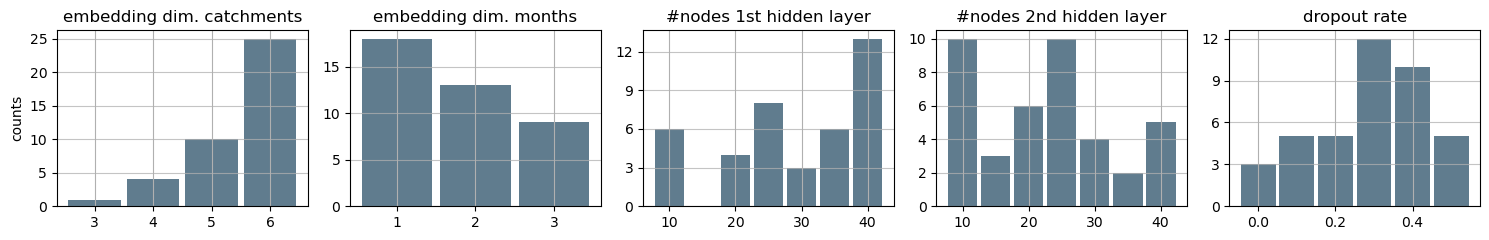

In [10]:
name_dict = dict(zip(df_hyperparameters.columns,['embedding dim. catchments','embedding dim. months', '#nodes 1st hidden layer', '#nodes 2nd hidden layer', 'dropout rate']))
df_hyperparameters.rename(columns=name_dict, inplace=True)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,2.5))
for i in range(len(df_hyperparameters.columns)):
    name = df_hyperparameters.columns[i]
    unique_values = np.sort(df_hyperparameters[name].unique())
    delta = round(min(np.diff(unique_values)),2)
    midpoints = np.arange(min(unique_values), max(unique_values)+0.01, delta)
    bins = list(midpoints-delta/2) + [midpoints[-1]+delta/2]
    hist = df_hyperparameters[name].hist(grid=True, bins=bins, rwidth=0.9, color='#607c8e', ax=axs[i])
    if np.any(hist.get_yticks()%1!=0):
        ymax = int(np.ceil(hist.get_ylim()[1]))
        ystep = int(np.ceil(np.diff(hist.get_yticks())[0]))
        yticks = [*range(0,ymax,ystep)]
        axs[i].set_yticks(yticks)
    axs[i].set_title(name)
    if i == 0:
        axs[i].set_ylabel('counts')
    axs[i].grid(axis='y', alpha=0.75)

plt.tight_layout()